In [55]:
import pandas as pd
import seaborn as sns
import numpy as np
import re
from collections import OrderedDict
import matplotlib.pyplot as plt



import pylab as plot
params = {'legend.fontsize': 20,
          'legend.handlelength': 2, 'axes.labelsize': 20, 'xtick.labelsize':20, 'ytick.labelsize':20}
plot.rcParams.update(params)


In [2]:
#plot.rcParams.keys()

## Data from the audio test

In [3]:
data = pd.read_excel("data.xlsx", usecols = [0,1,2,3,4])
data.head()

,ID,Instrument,timbre,heard_pitch,answered_pitch
0,1,piano,sin,c4,c
1,1,piano,sin,g#5,a
2,1,piano,sin,f4,f
3,1,piano,sin,a5,b
4,1,piano,sin,d#3,e


In [4]:
data = data.dropna()
#data = data[~(str(data['heard_pitch']) == 'nan') & ~(str(data['heard_pitch']) == 'NaN')]

# remove the octave annotations
data['heard_pitch'] = data['heard_pitch'].str.replace('[0-9 ]+', "")

In [5]:
# Convert the pitch heights into numbers to compute the difference 

pitch_dict = {
      'c':0, 'c#':1, 'db':1, 'd':2, 'd#':3, 'eb':3, 'e':4, 'fb':4, 'f':5, 'e#':5, 'f#':6, 'gb':6, 'g':5, 'g#':4, 'ab':4, 'a':3, 'a#':2, 'bb':2, 'b':1, 'cb':1, 'b#':0}

def pitch_to_int(x):
    if x in pitch_dict.keys():
        return pitch_dict[x]
    else:
        #print(x)
        return np.NaN

dataT = data.copy()
dataT['heard_pitch'] = dataT['heard_pitch'].apply(lambda x : pitch_to_int(x))
dataT['answered_pitch'] = dataT['answered_pitch'].apply(lambda x : pitch_to_int(x))

#dataT[dataT['heard_pitch'] == np.NaN]

In [6]:
# compute the diff and abs diff

dataT['diff'] = dataT['heard_pitch'] - dataT['answered_pitch']
dataT['abs_diff'] = abs(dataT['heard_pitch'] - dataT['answered_pitch'])
dataT.head()

,ID,Instrument,timbre,heard_pitch,answered_pitch,diff,abs_diff
0,1,piano,sin,0,0.0,0.0,0.0
1,1,piano,sin,4,3.0,1.0,1.0
2,1,piano,sin,5,5.0,0.0,0.0
3,1,piano,sin,3,1.0,2.0,2.0
4,1,piano,sin,3,4.0,-1.0,1.0


### Statistics

In [7]:
# mean global error
dataT['abs_diff'].mean()
dataT['diff'].mean()
#dataT['abs_diff'].groupby('ID').describe()
#dataT['abs_diff'].groupby('Instrument').describe()
dataT['diff'].describe()

count    1254.000000
mean        0.058214
std         2.084938
min        -6.000000
25%        -1.000000
50%         0.000000
75%         1.000000
max         6.000000
Name: diff, dtype: float64

## Data from the form 

In [8]:
form_data = pd.read_excel("form.xlsx", sheet_name = 'formated')
form_data = form_data[0:45]
form_data = form_data.dropna(how = 'all')
form_data.shape
form_data.head()

,id,instr_principal,instr_sec,age,estimated_cap,age_ap,family_ap,age_music_studies,rate_theory,rate_technique,...,band,ensemble,orchestra,band_other,scores,chords + tabs,improvising,hearing,by heart,other.1
0,1,piano,NaN,18,AP,8.0,0.0,4,8.0,5.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,2,saxophone,NaN,18,RP,NaN,0.0,6,7.0,6.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,3,trombone,NaN,19,RP,NaN,0.0,4,6.0,9.0,...,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,4,trombone,piano,26,RP,NaN,0.0,6,9.0,7.0,...,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
4,5,saxophone,NaN,25,RP,NaN,0.0,6,7.0,6.0,...,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [9]:
# number of different instruments
form_data.instr_principal.value_counts()

guitare        6
piano          5
trompette      4
violon         4
alto           3
trombone       3
violoncelle    3
saxophone      3
batterie       2
hautbois       1
clarinette     1
cor            1
Name: instr_principal, dtype: int64

In [10]:
# group the instr per class : wind, percussion, string
# -> wind, tuned / untuned percussions, fret / fretless strings ?

instr_dict = { 'piano' : 'percussion', 'batterie' : 'percussion',  
              'violon' : 'string', 'alto' : 'string', 'violoncelle' : 'string', 'guitare' : 'string',
              'contrebasse':'string', 'basse':'string',
              'trompette' : 'wind', 'trombone' : 'wind', 'saxophone' : 'wind', 'hautbois' : 'wind', 
              'clarinette' : 'wind', 'cor' : 'wind', 'flute':'wind', 'chant':'wind'
} # j'ai mis 'chant' dans 'wind'...

def instr_to_class(x):
    if x in instr_dict.keys():
        return instr_dict[x]
    else:
        #print(x)
        return np.NaN

formT = form_data.copy()
formT['instr_class'] = formT['instr_principal'].apply(lambda x : instr_to_class(x))
formT['instr_sec_class'] = formT['instr_sec'].apply(lambda x : instr_to_class(x))

formT.instr_class.value_counts()

string        16
wind          13
percussion     7
Name: instr_class, dtype: int64

In [11]:
# quantifié = 1, nonquantifié = 0 /!\ on ne sait pas dans quelle catégorie vont la batterie et la trompette
quant_dict = { 'piano' : 1, 'batterie' : 0,  
              'violon' : 0, 'alto' : 0, 'violoncelle' : 0, 'guitare' : 1,
              'contrebasse':0, 'basse':1,
              'trompette' : 1, 'trombone' : 0, 'saxophone' : 1, 'hautbois' : 1, 
              'clarinette' : 1, 'cor' : 1, 'flute':1, 'chant':0
}

def instr_to_quant(x):
    if x in quant_dict.keys():
        return quant_dict[x]
    else:
        #print(x)
        return np.NaN

formT['instr_quant'] = formT['instr_principal'].apply(lambda x : instr_to_quant(x))
formT['instr_sec_quant'] = formT['instr_sec'].apply(lambda x : instr_to_quant(x))

## Merged dataset

In [12]:
dataT.columns

Index([            u'ID',     u'Instrument',         u'timbre',
          u'heard_pitch', u'answered_pitch',           u'diff',
             u'abs_diff'],
      dtype='object')

In [13]:
merged_df = dataT.merge(formT, how = 'outer', left_on='ID', right_on='id')
merged_df.head()
merged_df = merged_df.drop(columns={'id', 'Instrument'})

In [14]:
writer = pd.ExcelWriter('merged_df.xlsx', engine='xlsxwriter')
merged_df.to_excel(writer, sheet_name='Sheet1')
writer.save()

merged_df.head()

,ID,timbre,heard_pitch,answered_pitch,diff,abs_diff,instr_principal,instr_sec,age,estimated_cap,...,scores,chords + tabs,improvising,hearing,by heart,other.1,instr_class,instr_sec_class,instr_quant,instr_sec_quant
0,1,sin,0,0.0,0.0,0.0,piano,NaN,18,AP,...,0.0,0.0,1.0,0.0,0.0,0.0,percussion,NaN,1,NaN
1,1,sin,4,3.0,1.0,1.0,piano,NaN,18,AP,...,0.0,0.0,1.0,0.0,0.0,0.0,percussion,NaN,1,NaN
2,1,sin,5,5.0,0.0,0.0,piano,NaN,18,AP,...,0.0,0.0,1.0,0.0,0.0,0.0,percussion,NaN,1,NaN
3,1,sin,3,1.0,2.0,2.0,piano,NaN,18,AP,...,0.0,0.0,1.0,0.0,0.0,0.0,percussion,NaN,1,NaN
4,1,sin,3,4.0,-1.0,1.0,piano,NaN,18,AP,...,0.0,0.0,1.0,0.0,0.0,0.0,percussion,NaN,1,NaN


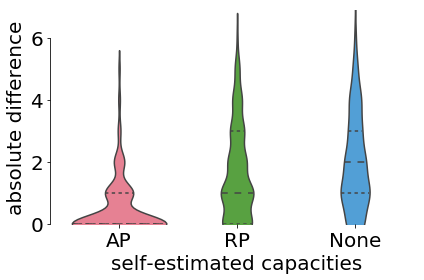

In [111]:
sns.violinplot(x = 'estimated_cap', y = 'abs_diff', data=merged_df, palette ='husl', inner = 'quart')
sns.despine(offset=10, trim=True, bottom = True)

plt.xlabel('self-estimated capacities')
plt.ylabel('absolute difference')
plt.ylim(0,6.9)

plt.tight_layout()
plt.savefig('fig1.png', dpi = 400)

## Grouped Boxplots
y axis = frequency, x axis = error (directionnal -> not absolute), box plots per instrument class (3 values)

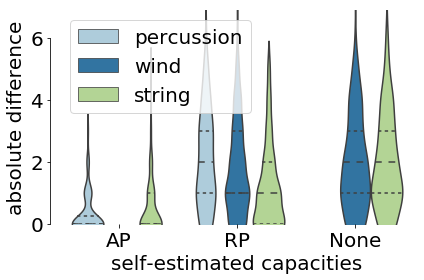

In [16]:
sns.violinplot(x = 'estimated_cap', y = 'abs_diff', hue='instr_class', data=merged_df, palette = 'Paired', inner = 'quart')
sns.despine(offset=10, trim=True, bottom = True, right=True)

#legend out of the figure
plt.legend(loc='upper left')

plt.xlabel('self-estimated capacities')
plt.ylabel('absolute difference')
plt.ylim(0,6.9)

plt.tight_layout()
plt.savefig('fig2.png', dpi = 400)

These boxplots show the absolute difference in the answers given by the participants, grouped per their estimated capacities (given by themselves), and separated by instrument class.

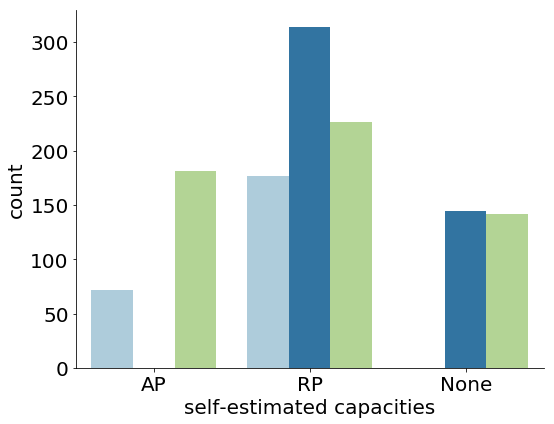

In [17]:
# estimated cap per instr class
sns.factorplot(x='estimated_cap', hue='instr_class', data=merged_df, kind="count",
                   palette="Paired", size=6, aspect=1.3, legend = None)

plt.xlabel('self-estimated capacities')
plt.ylabel('count')
plt.tight_layout()
plt.savefig('fig3.png', dpi = 400)

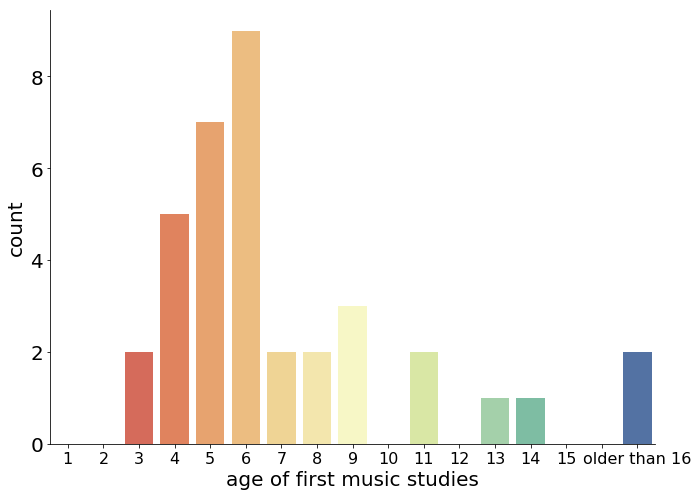

In [96]:
# histogram of age at which participants began their musical studies

sns.factorplot(x='age_music_studies', data = form_data, kind = 'count', order=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,' ','older than 16'],size=7, aspect=1.4, palette = 'Spectral')
plt.xlabel('age of first music studies')
plt.xticks(fontsize = 16)
plt.ylabel('count')
plt.tight_layout()
plt.savefig('fig4.png', dpi = 400)

count    1254.000000
mean        1.464912
std         1.484142
min         0.000000
25%         0.000000
50%         1.000000
75%         2.000000
max         6.000000
Name: abs_diff, dtype: float64

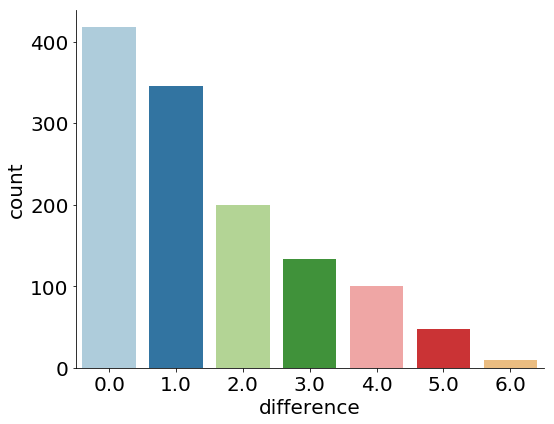

In [74]:
sns.factorplot(x='abs_diff', data = merged_df, kind = 'count',size=6, aspect=1.3, palette = 'Paired')
plt.xlabel('difference')
plt.ylabel('count')
plt.tight_layout()
plt.savefig('fig5.png', dpi = 400)

merged_df['abs_diff'].describe()

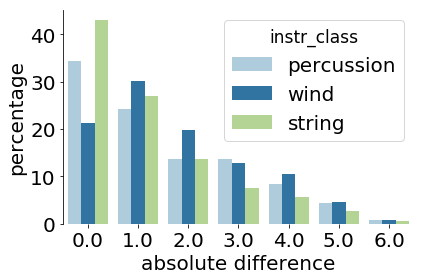

In [20]:
## ATTENTION ce plot n'est pas normalisé !! Maintenant oui hihi
"""
sns.factorplot(x = 'abs_diff', hue = 'instr_class', data = merged_df, kind = 'count',size=6, aspect=1.3, palette = 'Paired', legend=None)
plt.xlabel('difference', fontsize = 14)
plt.ylabel('count', fontsize=14)
plt.legend(fontsize = 14)
plt.tight_layout()
plt.savefig('fig6.png', dpi = 400)
"""
hist_count = (merged_df.groupby(['instr_class'])['abs_diff']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('abs_diff'))
p = sns.barplot(x="abs_diff", y="percentage", hue="instr_class", data=hist_count, palette = 'Paired')
sns.despine(bottom = True)
plt.xlabel('absolute difference')
plt.ylabel('percentage')
plt.tight_layout()
plt.savefig('fig6.png', dpi = 400)

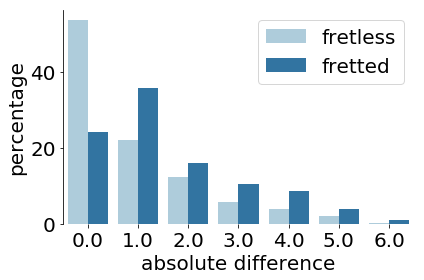

In [21]:
string_df = merged_df[merged_df.instr_class == 'string']

string_count = (string_df.groupby(['instr_quant'])['abs_diff']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('abs_diff'))
p = sns.barplot(x="abs_diff", y="percentage", hue="instr_quant", data=string_count, palette = 'Paired')
plt.xlabel('absolute difference')
plt.ylabel('percentage')
sns.despine(bottom = True)
L=plt.legend()
L.get_texts()[0].set_text('fretless')
L.get_texts()[1].set_text('fretted')

plt.tight_layout()
plt.savefig('fig_hist_string.png', dpi = 400)

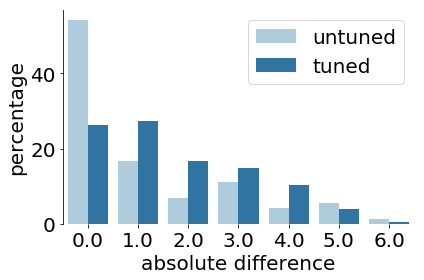

In [115]:
perc_df = merged_df[merged_df.instr_class == 'percussion']

perc_count = (perc_df.groupby(['instr_quant'])['abs_diff']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('abs_diff'))
p = sns.barplot(x="abs_diff", y="percentage", hue="instr_quant", data=perc_count, palette = 'Paired')
plt.xlabel('absolute difference')
plt.ylabel('percentage')
sns.despine(bottom = True)
L=plt.legend()
L.get_texts()[0].set_text('untuned')
L.get_texts()[1].set_text('tuned')

plt.tight_layout()
plt.savefig('fig_hist_perc.png', dpi = 400)

In [23]:
merged_df.columns


Index([               u'ID',            u'timbre',       u'heard_pitch',
          u'answered_pitch',              u'diff',          u'abs_diff',
         u'instr_principal',         u'instr_sec',               u'age',
           u'estimated_cap',            u'age_ap',         u'family_ap',
       u'age_music_studies',       u'rate_theory',    u'rate_technique',
               u'rate_hear',       u'genres_play',     u'genres_listen',
                 u'classic',              u'jazz',              u'funk',
                     u'pop',              u'rock',             u'metal',
                   u'other',              u'solo',              u'band',
                u'ensemble',         u'orchestra',        u'band_other',
                  u'scores',     u'chords + tabs',       u'improvising',
                 u'hearing',          u'by heart',           u'other.1',
             u'instr_class',   u'instr_sec_class',       u'instr_quant',
         u'instr_sec_quant'],
      dtype='object')

In [75]:
# group per string vs not string

string_dict = { 'string' : 1, 'percussion' : 0,  'wind' : 0
              }

def string(x):
    if x in string_dict.keys():
        return string_dict[x]
    else:
        #print(x)
        return np.NaN

string_df = merged_df[['ID','abs_diff', 'diff', 'instr_class', 'instr_quant']]
string_df['string'] = string_df['instr_class'].apply(lambda x : string(x))

/Users/Albane/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,count,mean,std,min,25%,50%,75%,max
instr_class,,,,,,,,
percussion,247.0,1.542510,1.558224,0.0,0.0,1.0,3.0,6.0
string,549.0,1.162113,1.387228,0.0,0.0,1.0,2.0,6.0
wind,458.0,1.786026,1.485915,0.0,1.0,1.0,3.0,6.0


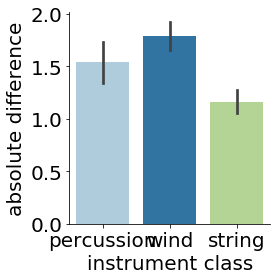

In [63]:
# plot error bars per instr class

sns.factorplot(x = 'instr_class', y = 'abs_diff', data= string_df, kind = 'bar', palette='Paired')
plt.ylabel('absolute difference')
plt.xlabel('instrument class')
plt.tight_layout()
plt.savefig('fig_string1.png', dpi=400)

string_df.groupby('instr_class')['abs_diff'].describe()

,count,mean,std,min,25%,50%,75%,max
string,,,,,,,,
0,705.0,1.700709,1.515005,0.0,0.0,1.0,3.0,6.0
1,549.0,1.162113,1.387228,0.0,0.0,1.0,2.0,6.0


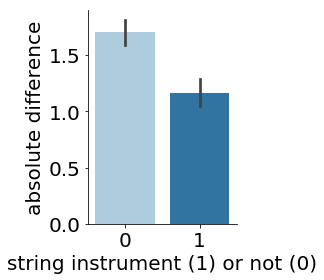

In [64]:
# same but string vs not string 

sns.factorplot(x = 'string', y = 'abs_diff', data=string_df, kind = 'bar', palette='Paired')
plt.xlabel('string instrument (1) or not (0)')
plt.ylabel('absolute difference')
plt.tight_layout()
plt.savefig('fig_string2.png', dpi = 400)

string_df.groupby('string')['abs_diff'].describe()

,count,mean,std,min,25%,50%,75%,max
instr_quant,,,,,,,,
0,350.0,0.914286,1.279582,0.0,0.0,0.0,1.0,6.0
1,199.0,1.597990,1.463080,0.0,1.0,1.0,2.0,6.0


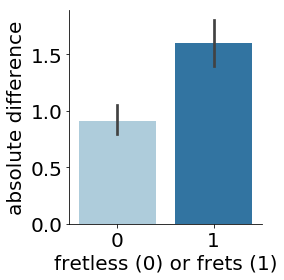

In [65]:
# same but fretless vs "fretted" among string 
fret_df = string_df[string_df.instr_class == 'string']
fret_df

sns.factorplot(x = 'instr_quant', y = 'abs_diff', data = fret_df, kind ='bar', palette='Paired')
plt.xlabel('fretless (0) or frets (1)')
plt.ylabel('absolute difference')
plt.tight_layout()
plt.savefig('fig_fretless.png', dpi = 400)

fret_df.groupby('instr_quant')['abs_diff'].describe()

piano       5.0
batterie    2.0
Name: Instrument, dtype: float64


,count,mean,std,min,25%,50%,75%,max
Instrument,,,,,,,,
batterie,72.0,1.166667,1.635866,0.0,0.0,0.0,2.0,6.0
piano,175.0,1.697143,1.502772,0.0,0.0,1.0,3.0,6.0


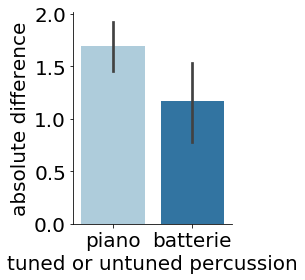

In [71]:
# percussions : tuned (piano) vs untuned (batterie)
perc1 = dataT[dataT.Instrument == 'piano']
perc2 = dataT[dataT.Instrument == 'batterie']
perc = [perc1, perc2]
perc_df = pd.concat(perc)

sns.factorplot(x = 'Instrument', y = 'abs_diff', data = perc_df, kind ='bar', palette='Paired')
plt.xlabel('tuned or untuned percussion')
plt.ylabel('absolute difference')
plt.tight_layout()
plt.savefig('fig_tuned_perc_bars.png', dpi = 400)

print(np.ceil(perc_df.Instrument.value_counts() / 36))
perc_df.groupby('Instrument')['abs_diff'].describe()

/Users/Albane/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


piano        35.0
sin          34.0
violin        9.0
wurli         7.0
trombone      7.0
saxophone     4.0
guitar        4.0
trompette     1.0
Name: timbre, dtype: float64


,count,mean,std,min,25%,50%,75%,max
timbre_class,,,,,,,,
other,413.0,1.433414,1.477517,0.0,0.0,1.0,2.0,6.0
piano,427.0,1.461358,1.509059,0.0,0.0,1.0,2.0,6.0
sin,414.0,1.500000,1.467567,0.0,0.0,1.0,2.0,6.0


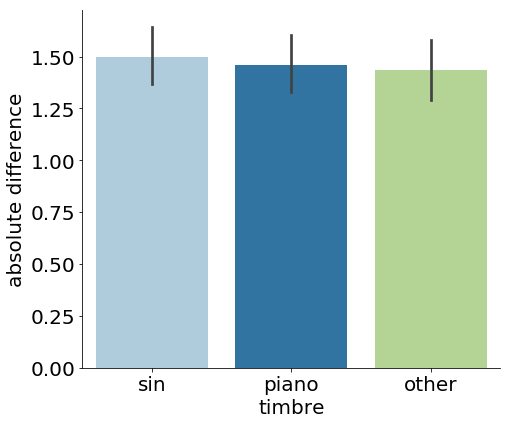

In [66]:
timbre_dict = { 'sin' : 'sin', 'piano' : 'piano',  'violin' : 'other', 'trombone' : 'other', 'wurli' : 'other', 'guitar': 'other', 'saxophone' : 'other', 'trompette': 'other'}
              

def timbre(x):
    if x in timbre_dict.keys():
        return timbre_dict[x]
    else:
        #print(x)
        return np.NaN

timbre_df = dataT[['abs_diff', 'diff', 'timbre']]
timbre_df['timbre_class'] = timbre_df['timbre'].apply(lambda x : timbre(x))


#string_df.string.value_counts()
#string_df.head()
#string_df.groupby('instr_class')['abs_diff'].describe()

#timbre_df = dataT[(dataT.timbre == 'sin')|(dataT.timbre == 'piano')] # | dataT.timbre == 'piano']

sns.factorplot(x = 'timbre_class', y = 'abs_diff', data = timbre_df, kind ='bar', palette='Paired', size=6, aspect= 1.2)
plt.xlabel('timbre')
plt.ylabel('absolute difference')
plt.tight_layout()
plt.savefig('fig_timbre.png', dpi = 400)

print(np.floor(dataT.timbre.value_counts() / 12))
timbre_df.groupby('timbre_class')['abs_diff'].describe()

In [29]:
# average difference
merged_df.groupby('instr_class')['abs_diff'].describe()
merged_df.columns

Index([               u'ID',            u'timbre',       u'heard_pitch',
          u'answered_pitch',              u'diff',          u'abs_diff',
         u'instr_principal',         u'instr_sec',               u'age',
           u'estimated_cap',            u'age_ap',         u'family_ap',
       u'age_music_studies',       u'rate_theory',    u'rate_technique',
               u'rate_hear',       u'genres_play',     u'genres_listen',
                 u'classic',              u'jazz',              u'funk',
                     u'pop',              u'rock',             u'metal',
                   u'other',              u'solo',              u'band',
                u'ensemble',         u'orchestra',        u'band_other',
                  u'scores',     u'chords + tabs',       u'improvising',
                 u'hearing',          u'by heart',           u'other.1',
             u'instr_class',   u'instr_sec_class',       u'instr_quant',
         u'instr_sec_quant'],
      dtype='object')

In [30]:
merged_df.instr_class.value_counts() / 36


string        15.250000
wind          12.722222
percussion     6.916667
Name: instr_class, dtype: float64

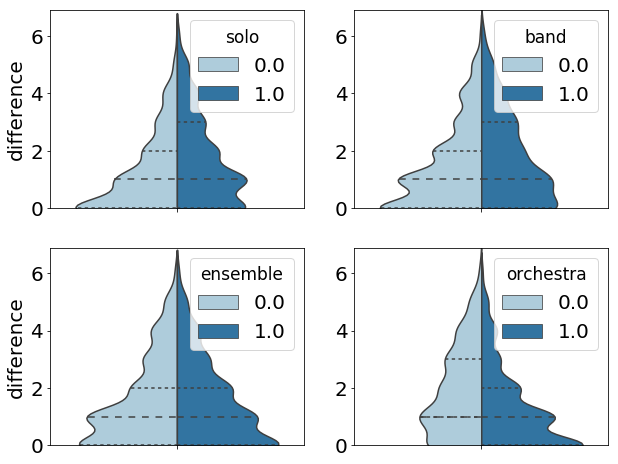

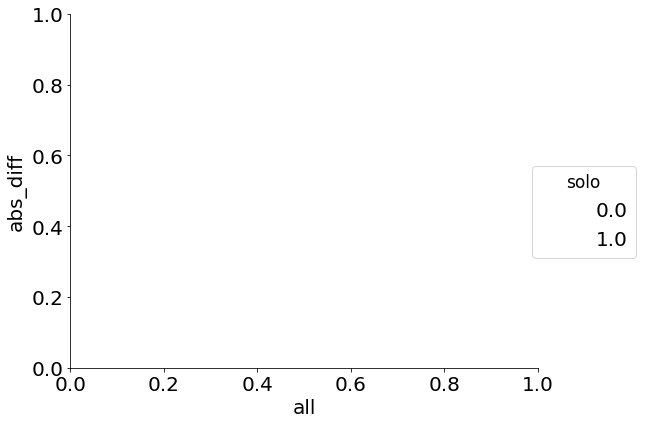

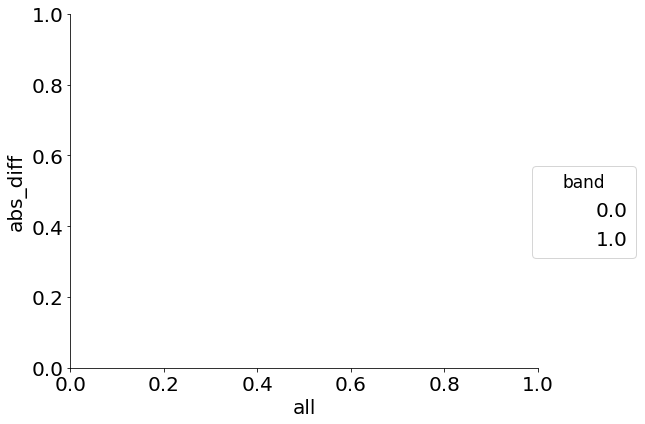

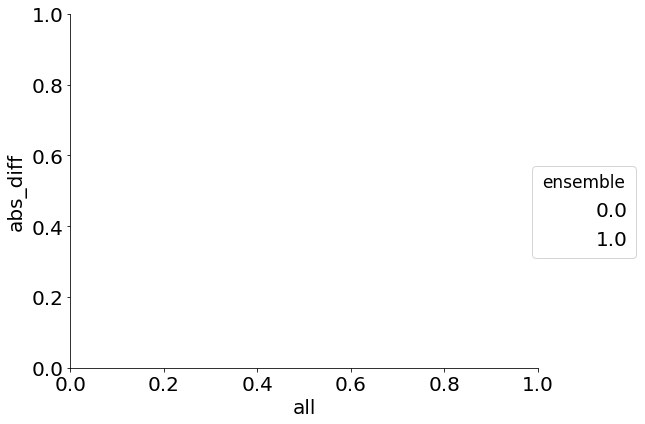

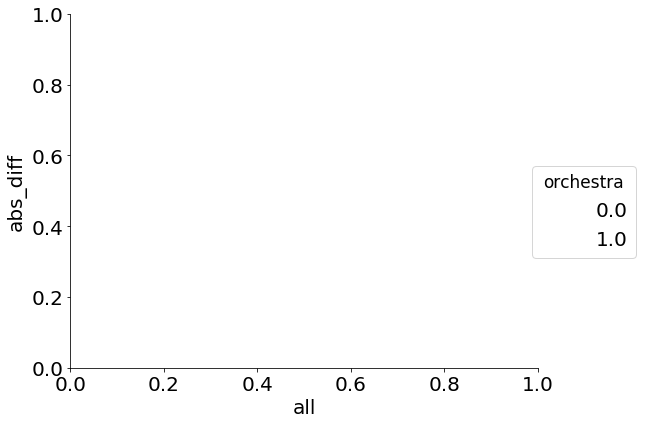

In [130]:
#sns.violinplot(x=['solo', 'band'], y='diff', hue = 'family_ap', data = merged_df, split = True)
fig7 = plt.figure(figsize=(10,8))
ax1 = fig7.add_subplot(221)
ax2 = fig7.add_subplot(222)
ax3 = fig7.add_subplot(223)
ax4 = fig7.add_subplot(224)

merged_df["all"] = ""
sns.factorplot(x = 'all', y ='abs_diff', hue = 'solo', data = merged_df, kind = 'violin',size=6, aspect=1.3, palette = 'Paired', split = True, ax = ax1, inner = 'quart')
sns.factorplot(x = 'all', y ='abs_diff', hue = 'band', data = merged_df, kind = 'violin',size=6, aspect=1.3, palette = 'Paired', split = True, ax = ax2, inner = 'quart')
sns.factorplot(x = 'all', y ='abs_diff', hue = 'ensemble', data = merged_df, kind = 'violin',size=6, aspect=1.3, palette = 'Paired', split = True, ax = ax3, inner = 'quart')
sns.factorplot(x = 'all', y ='abs_diff', hue = 'orchestra', data = merged_df, kind = 'violin',size=6, aspect=1.3, palette = 'Paired', split = True, ax = ax4, inner = 'quart')

ax1.set_xlabel('')
ax2.set_xlabel('')
ax3.set_xlabel('')
ax4.set_xlabel('')

ax1.set_ylabel('difference')
ax2.set_ylabel('')
ax3.set_ylabel('difference')
ax4.set_ylabel('')


ax1.set_ylim(-0,6.9)
ax2.set_ylim(-0,6.9)
ax3.set_ylim(-0,6.9)
ax4.set_ylim(-0,6.9)

fig7.savefig('fig7.png', dpi = 400)



In [81]:
merged_df.groupby('solo')['abs_diff']


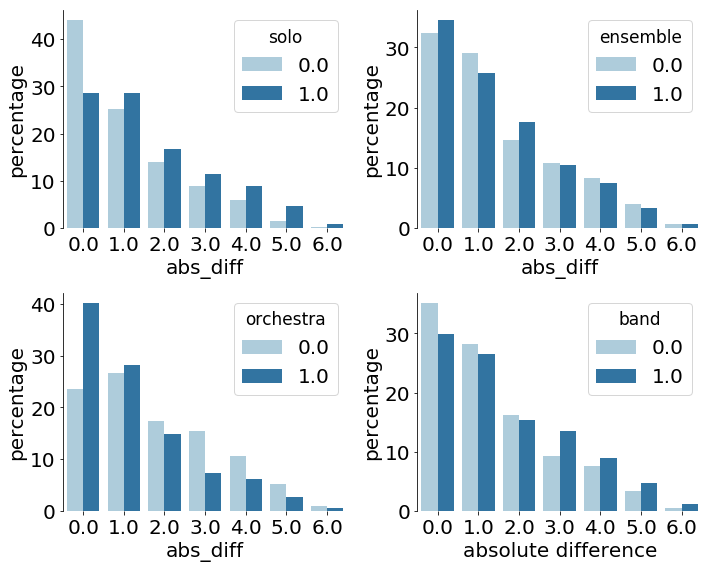

In [127]:
fig7 = plt.figure(figsize=(10,8))


solo_count = (merged_df.groupby(['solo'])['abs_diff']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('abs_diff'))
plt.subplot(221)
sns.barplot(x="abs_diff", y="percentage", hue="solo", data=solo_count, palette = 'Paired')

ensemble_count = (merged_df.groupby(['ensemble'])['abs_diff']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('abs_diff'))
plt.subplot(222)
sns.barplot(x="abs_diff", y="percentage", hue="ensemble", data=ensemble_count, palette = 'Paired')

orchestra_count = (merged_df.groupby(['orchestra'])['abs_diff']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('abs_diff'))
plt.subplot(223)
sns.barplot(x="abs_diff", y="percentage", hue="orchestra", data=orchestra_count, palette = 'Paired')

band_count = (merged_df.groupby(['band'])['abs_diff']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('abs_diff'))
plt.subplot(224)
sns.barplot(x="abs_diff", y="percentage", hue="band", data=band_count, palette = 'Paired')

plt.xlabel('absolute difference')
plt.ylabel('percentage')
sns.despine(bottom = True)

plt.tight_layout()
plt.savefig('fig_habits.png', dpi = 400)

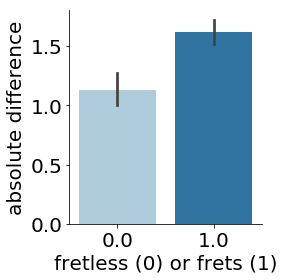

In [83]:
# same but fretless vs "fretted" among string 


sns.factorplot(x = 'solo', y = 'abs_diff', data = merged_df, kind ='bar', palette='Paired')
plt.xlabel('fretless (0) or frets (1)')
plt.ylabel('absolute difference')
plt.tight_layout()
plt.savefig('fig_fretless.png', dpi = 400)



In [32]:
merged_df['diff'].describe()

count    1254.000000
mean        0.058214
std         2.084938
min        -6.000000
25%        -1.000000
50%         0.000000
75%         1.000000
max         6.000000
Name: diff, dtype: float64

In [33]:
merged_df.genres_play.value_counts() /36

classic                              8.750000
classic, jazz                        6.805556
jazz                                 5.583333
blues                                2.000000
classic, folk, pop                   1.055556
rock, metal                          1.000000
brass                                1.000000
classic, rock                        1.000000
classic, funk, rock, metal, jazz     1.000000
rock                                 0.972222
classic, jazz, hip hop, rock         0.972222
classic, romantic, jazz              0.972222
classic, jazz, funk                  0.972222
jazz, funk, rock                     0.944444
jazz, classic, bossa, funk, disco    0.944444
jazz, classic, rock                  0.916667
Name: genres_play, dtype: float64

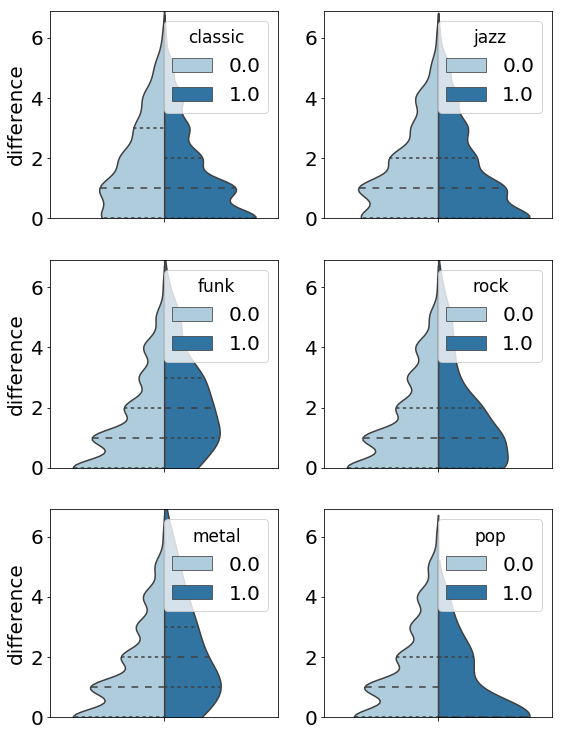

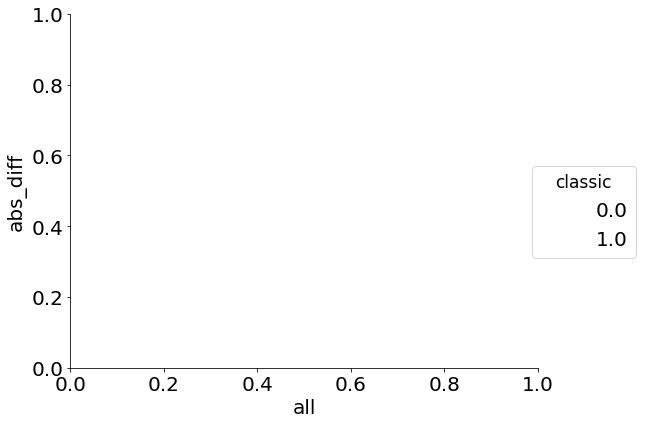

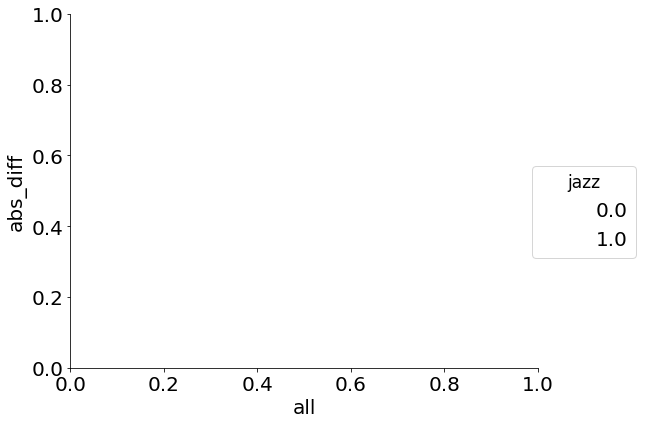

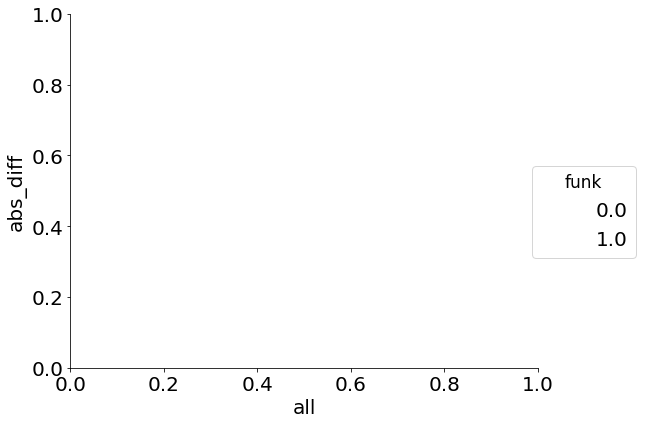

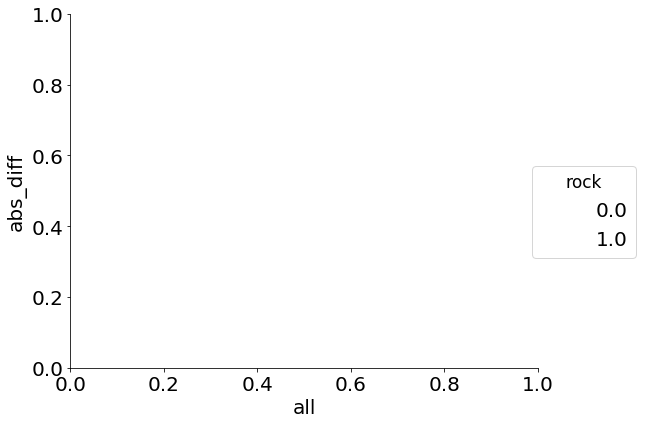

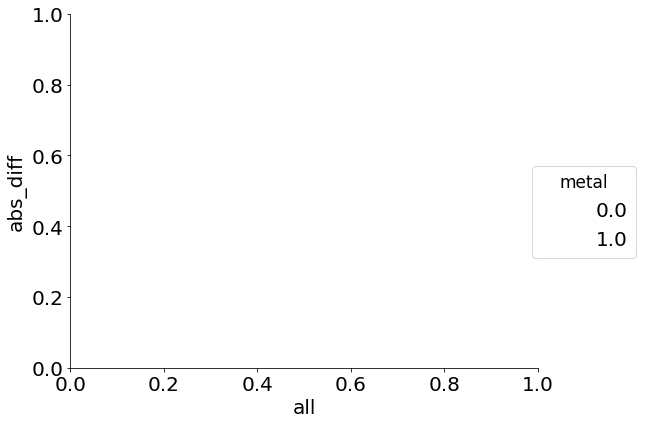

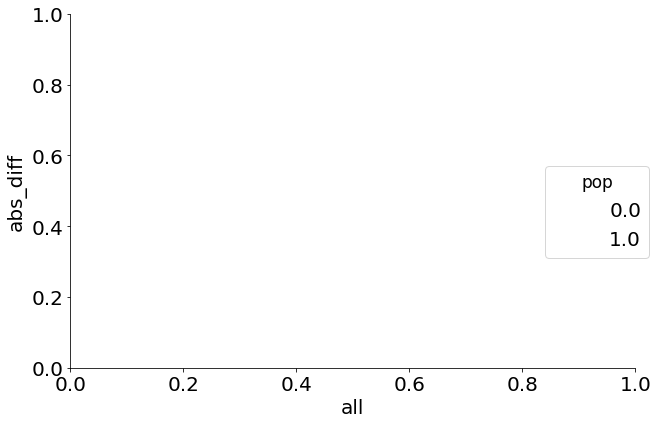

In [136]:
#sns.violinplot(x=['solo', 'band'], y='diff', hue = 'family_ap', data = merged_df, split = True)
fig9 = plt.figure(figsize=(9,13))
ax1 = fig9.add_subplot(321)
ax2 = fig9.add_subplot(322)
ax3 = fig9.add_subplot(323)
ax4 = fig9.add_subplot(324)
ax5 = fig9.add_subplot(325)
ax6 = fig9.add_subplot(326)

sns.factorplot(x = 'all', y ='abs_diff', hue = 'classic', data = merged_df, kind = 'violin',size=6, aspect=1.3, palette = 'Paired', ax = ax1, split = True, inner = 'quart')
sns.factorplot(x = 'all', y ='abs_diff', hue = 'jazz', data = merged_df, kind = 'violin',size=6, aspect=1.3, palette = 'Paired', ax = ax2, split = True, inner = 'quart')
sns.factorplot(x = 'all', y ='abs_diff', hue = 'funk', data = merged_df, kind = 'violin',size=6, aspect=1.3, palette = 'Paired', ax = ax3, split = True, inner = 'quart')
sns.factorplot(x = 'all', y ='abs_diff', hue = 'rock', data = merged_df, kind = 'violin',size=6, aspect=1.3, palette = 'Paired', ax = ax4, split = True, inner = 'quart')
sns.factorplot(x = 'all', y ='abs_diff', hue = 'metal', data = merged_df, kind = 'violin',size=6, aspect=1.3, palette = 'Paired', ax = ax5, split = True, inner = 'quart')
sns.factorplot(x = 'all', y ='abs_diff',hue = 'pop', data = merged_df, kind = 'violin',size=6, aspect=1.3, palette = 'Paired', ax = ax6, split = True, inner = 'quart')

ax1.set_xlabel('')
ax2.set_xlabel('')
ax3.set_xlabel('')
ax4.set_xlabel('')
ax5.set_xlabel('')
ax6.set_xlabel('')

ax1.set_ylim(0,6.9)
ax2.set_ylim(0,6.9)
ax3.set_ylim(0,6.9)
ax4.set_ylim(0,6.9)
ax5.set_ylim(0,6.9)
ax6.set_ylim(0,6.9)

ax1.set_ylabel('difference')
ax2.set_ylabel('')
ax3.set_ylabel('difference')
ax4.set_ylabel('')
ax5.set_ylabel('difference')
ax6.set_ylabel('')

plt.tight_layout()
fig9.savefig('fig9.png', dpi = 400)

# attention les légendes ne s'affichent pas bien


In [36]:
#merged_df[merged_df.jazz == 1]

In [37]:
serie = merged_df[['age','age_music_studies']]

serie['age_music_studies'] = serie['age_music_studies'].replace('older than 16', 16)
serie['age_tot'] = serie['age'] - serie['age_music_studies']
serie['age_tot'].mean()

/Users/Albane/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/Albane/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


15.535828025477707

In [38]:
merged_df.columns


Index([               u'ID',            u'timbre',       u'heard_pitch',
          u'answered_pitch',              u'diff',          u'abs_diff',
         u'instr_principal',         u'instr_sec',               u'age',
           u'estimated_cap',            u'age_ap',         u'family_ap',
       u'age_music_studies',       u'rate_theory',    u'rate_technique',
               u'rate_hear',       u'genres_play',     u'genres_listen',
                 u'classic',              u'jazz',              u'funk',
                     u'pop',              u'rock',             u'metal',
                   u'other',              u'solo',              u'band',
                u'ensemble',         u'orchestra',        u'band_other',
                  u'scores',     u'chords + tabs',       u'improvising',
                 u'hearing',          u'by heart',           u'other.1',
             u'instr_class',   u'instr_sec_class',       u'instr_quant',
         u'instr_sec_quant',               u'all'],

,count,mean,std,min,25%,50%,75%,max
instr_quant,,,,,,,,
0,527.0,1.132827,1.428061,0.0,0.0,1.0,2.0,6.0
1,727.0,1.705640,1.478499,0.0,1.0,1.0,3.0,6.0


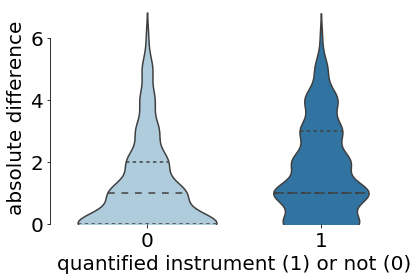

In [67]:
sns.violinplot(x = 'instr_quant', y = 'abs_diff', data=merged_df, palette ='Paired', inner = 'quart')
sns.despine(offset=10, trim=True, bottom = True)
plt.ylim(0,6.9)
plt.xlabel('quantified instrument (1) or not (0)') #f.ex. piano = 1
plt.ylabel('absolute difference')
plt.tight_layout()
plt.savefig('fig10.png', dpi = 400)

merged_df.groupby('instr_quant')['abs_diff'].describe()

In [41]:
dataT.Instrument.value_counts() / 36

guitare        5.527778
piano          4.916667
violon         3.916667
trompette      3.888889
alto           3.055556
saxophone      2.916667
trombone       2.916667
violoncelle    2.750000
batterie       2.000000
cor            1.000000
hautbois       1.000000
clarinette     1.000000
Name: Instrument, dtype: float64

## Heatmap


In [42]:
heatmap_df = pd.read_excel('heatmap_form.xlsx')

#merged_heatmap_df = heatmap_df.merge(dataT, how = 'outer', right_on = 'ID', left_on= 'id')
"""mean_df = dataT.groupby('ID')['abs_diff'].mean() # -> to add in the excel
mean_df.values"""
heatmap_df

,mean_diff,genres,habits
0,1.372933,jazz,solo
1,1.692277,classic,solo
2,1.411765,classic,band
3,1.574346,jazz,orchestra
4,1.793651,rock,solo
5,0.138889,jazz,band
6,0.737103,classic,orchestra
7,1.861112,blues,band
8,1.557748,other,solo


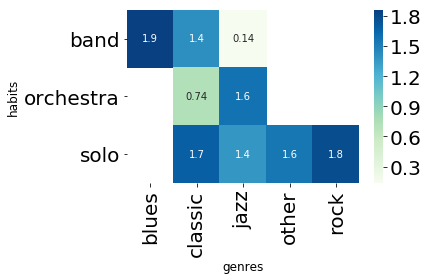

In [43]:
heatmap_df = heatmap_df[['genres', 'habits', 'mean_diff']]
heatmap_pivot_df = heatmap_df.pivot(index='habits', columns='genres', values='mean_diff')
sns.heatmap(heatmap_pivot_df, annot=True, cmap='GnBu')
plt.xlabel('genres',fontsize=12)
plt.ylabel('habits',fontsize=12)
plt.tight_layout()
plt.savefig('fig_heatmap.png', dpi=400)